# Documentation for diskint2

In this notebook, we provide some derivations of the equations used in the calculation of the synthetic profiles. 

Table of content:
1. Notes on the hardcoded constants in the codes
2. The weak solution derived from the Unno solution (and illustration of when the Weak solution is not valid)
3. The expressions for the angles used in the Unno solution
4. The correspondance between the slope of the source function and the $\epsilon$ limb-darkening parameter from Grey
5. The analytical rotation-broadened profiles

## 0. Importing the necessary packages

In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt

import pyRaven as rav

loading specpolFlow package


## 1. Notes on the hardcoded constants in the codes

**For the Unno calculation:**

The profile functions that needs to be calculated are 
$$\frac{1}{\sqrt{\pi}}\sum_i S_i H(u_o+u_{B,i} - u_\mathrm{LOS}), $$

where
$$u_{B,i}=\left[ \frac{\Delta \lambda_B}{\lambda_B}\right] * u_B.$$
The term in bracket is what is returned by the Zeeman pattern function: 

$$u_B = \frac{\lambda_B}{\Delta\lambda_D}= \frac{\frac{\lambda_o^2}{c} \left[\frac{e_oB}{4\pi m_e c}\right]}{\frac{\lambda_o v_D}{c}}$$

In the rightmost equation, the first $c$ is in the units that matches the wavelength ($Å$/s) and the bracket terms is the Larmor frequency (Hz) so the $c$ in the bracket is in cm/s. This makes the whole numerator to be in wavelength unit. 

The denominator also needs to be in wavelength units. So the $c$ in the denominator must match the units of $v_D$, so here km/s. 

In the disk integration, $B$ will change from cell to cell, but $\lambda_o$ and $v_D$ are set for a given model. So we can re-write this as:

$$u_B = B[\mathrm{G}] ~~ \frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]}~~ \frac{c[\mathrm{km/s}]}{c[\mathrm{Å/s}]} ~~\left[\frac{e_o[\mathrm{esu}]}{4\pi m_e[\mathrm{g}] ~~c[\mathrm{cm/s}]}\right]$$

or

$$u_B = B[\mathrm{G}] ~~ \frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]} ~~\left[\frac{e_o}{4\pi m_e ~~c}\right] = 1.399624\times10^{-7}~~ B[\mathrm{G}] ~~ \frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]} $$

where we ask the astropy unit package below to give us the term in bracket in explicit units of $\frac{\mathrm{km/s}}{\mathrm{G}~ Å}$, so that $\lambda_o$, $v_D$ and later on $B$ will be entered with numerical values in $Å$, km/s, and G. 

In the code, it is setup this way:

$$u_B =  \left[1.399624\times10^{-7}\frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]}\right] ~~ B[\mathrm{G}], $$
where the constant is `constLorentz` and the term in parenthesis is calculated early on as `perGaussLorentz`.

**For the weak-field calculation:**

The expression for Stokes V is:
$$V(\lambda) = -\lambda_B g_\mathrm{eff} \cos\theta \frac{dI}{d\lambda}$$

However, in our calculations we like to work in Doppler units ($u_o$). So we can first change the derivative from wavelength to velocity (in km/s):

$$V(v) = -\lambda_B g_\mathrm{eff} \cos\theta \frac{dI}{dv} \frac{c[\mathrm{km/s}]}{\lambda_o[Å]}$$

where the units of $c$ matches the units of the velocity. 

Next, we can make the transformation to the thermal Doppler velocity unit ($u_o = v/v_D$):

$$V(u_o) = -\lambda_B g_\mathrm{eff} \cos\theta \frac{dI}{du_o} \frac{c[\mathrm{km/s}]}{v_D[\mathrm{km/s}]\lambda_o[Å]}$$

Now we can expand $\lambda_B$ like above:

$$V(u_o) = - \frac{\lambda_o^2}{c[\mathrm{Å/s}]} \left[\frac{e_oB}{4\pi m_e c[\mathrm{cm/s}]}\right] g_\mathrm{eff} \cos\theta \frac{dI}{du_o} \frac{c[\mathrm{km/s}]}{v_D[\mathrm{km/s}]\lambda_o[Å]}$$

We can now re-organize a bit, noting that $B$ and $\cos\theta$ will be different on the surface, but $\lambda_o$ and $g_\mathrm{eff}$ will be the same for a given model:

$$V(u_o) = - B \cos\theta ~~ g_\mathrm{eff} \frac{\lambda_o}{v_D} ~~ \frac{c[\mathrm{km/s}]}{c[\mathrm{Å/s}]} ~~\left[\frac{e_o[\mathrm{esu}]}{4\pi m_e[\mathrm{g}] ~~c[\mathrm{cm/s}]}\right] \frac{dI}{du_o}  $$

or

$$ V(u_o) =  1.399624\times10^{-7}~~ B[\mathrm{G}] \cos\theta ~~ g_\mathrm{eff}\frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]}  \frac{dI}{du_o}$$

As can be seen, for both the Unno and Weak-field method, we can hardcode the same constant. 

In the codes, it is setup this way:

$$ V(u_o) =  \left[1.399624\times10^{-7}~\frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]} \right] g_\mathrm{eff} \cos\theta ~~ B[\mathrm{G}]  \frac{dI}{du_o}$$ 
where the constant is `constLorentz` and the term in parenthesis is calculated early on as `perGaussLorentz`.


In [2]:
G_cgs = u.def_unit('G_cgs', 1 * u.g**0.5/u.cm**0.5/u.s)

constant = ( const.e.esu / (4*np.pi*const.m_e*const.c) ).to(u.km/u.s/(G_cgs*u.AA)) 
print(constant)


# Just checking that muB is what it's supposed to be
# This is typical values for NGC 1624-2 CIV lines. 
B = 20e3*G_cgs
vdop = 6.44 *u.km/u.s # for carbon at 30000K
wave0 = 5811.98 * u.AA

muB = B*wave0/vdop * constant

print(muB)

print(const.c.to(u.km/u.s))

1.3996244936166518e-07 km / (Angstrom G_cgs s)
2.526270051059039
299792.458 km / s


## 2. The weak solution derived from the Unno solution (and illustration of when the Weak solution is not valid)

The weak-field local profile should be the same as the unno local profile when the field strength is set to zero. 

If $B=0$, then $\phi_p = \phi_r = \phi_b = \phi$. All of the elements of the propagation matrix therefore goes to zero, except $\eta_I = 1+\kappa\phi$. Also, $\Delta=\eta_I^4$. 

In the emerging intensity for the Unno solution reduces to:
$$I(0) = S_0 + \frac{\eta^3}{\Delta} S_1 = 1 + \frac{1}{\eta} \mu S_1$$
In the latter equality, I have made the intercept of the source function unity, and the slope of the source function $S_1$ (`bnu` variable in the code) is the vertical slope which needs to be multiply by the cos of the angle between the local ray and the normal to the surface ($\mu$).
Replacing the $\eta_I$ with its value above yields:
$$I(0) = 1 + \frac{1}{1+\kappa \phi}\mu S_1.$$

Now, in the case of a purely longitudinal field: we can set $\theta=0$ in the definitions of the propagation matrix elements. We also know that $\phi_r$ and $\phi_b$ will be the same as $\phi_p$ but with a tiny tiny shift to the red and blue (we are here using a triplet approximation already). Here are the elements of the matrix that are not zero:

$$\eta_I = 1 + \kappa \frac{\phi_b-\phi_r}{2} \simeq 1 + \kappa \phi$$
where for the last approximation, we are telling ourselves that the mean of $\phi_r$ and $\phi_b$ is basically just $\phi$ is the shift is very small. 

$$\eta_V = \frac{\kappa}{2}\left[\phi_b-\phi_r\right] = \frac{\kappa}{2}\left[\phi(u+g_\mathrm{eff}u_B)-\phi(u-g_\mathrm{eff}u_B)\right]. $$
Using the fact that $f(x+a)-f(x-a) = 2a \frac{f(x)}{dx}$, yields:

$$\eta_V  \simeq \kappa g_\mathrm{eff}u_B\frac{d\phi(u)}{du}$$

Similarly, 
$$\rho_V \simeq \kappa g_\mathrm{eff}u_B\frac{d\psi(u)}{du}$$

Using only the non-zero elements, we can write

$$\Delta = \eta_I^2(\eta_I^2-\eta_V^2+\rho_V^2) - (\eta_V\rho_V)^2$$
and
$$V(0) = -\frac{1}{\Delta} [\eta_I^2\eta_V + \rho_V(\eta_V\rho_V)]\mu S_1$$

Combining together (and leaving the $-\mu S_1$ term on the left side for a moment)

$$\frac{-V(0)}{\mu S_1} = \frac{\eta_I^2\eta_V+\eta_V\rho_V^2}{\eta_I^4 - \eta_I^2\eta_V^2 + (\eta_I^2-\eta_V^2)\rho_V^2} $$
(Intuitively, I know that the weak field approximation we use for e.g. the Bz calculation does not depends on the dispersion profile $\psi$, so the $\rho_V$ element must cancel out, and the best way is with factorization)
$$\frac{-V(0)}{\mu S_1} = \frac{\eta_V(\eta_I^2+\rho_V^2)}{(\eta_I^2-\eta_V^2)\eta_I^2+(\eta_I^2-\eta_V^2)\rho_V^2} = \frac{\eta_V(\eta_I^2+\rho_V^2)}{(\eta_I^2-\eta_V^2)(\eta_I^2+\rho_V^2)}=\frac{\eta_V}{(\eta_I^2-\eta_V^2)}$$
or
$$V(0)=-\mu S_1~\frac{\eta_V}{(\eta_I^2-\eta_V^2)} $$

Before we replace with the elements of the propagation matrix, there is another approximation that is, I believe, justified. In the bottom term, we could ignore $\eta_V^2$ if $\eta_V^2 << \eta_I^2$. So let's have a quick look at that. 

> As a reminder:
>
> $\eta_I = 1 + \kappa \phi$
>
> $\eta_V = \kappa g_\mathrm{eff}u_B\frac{d\phi(u)}{du}$
>

The figure below shows that $\phi$ and $\frac{d\phi(u)}{du}$ are both of the order of unity. The dashed line shows that a $u_B$ of about 0.1 would still (barely) satisfy our requirement that the shift between $\sigma_r$ and $\sigma_b$ is much smaller than the width of the profile. 

Text(0.5, 1.0, 'Fig. 1')

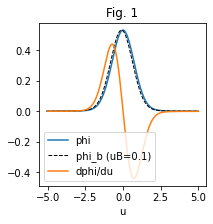

In [3]:
u = np.linspace(-5,5,300)
phi = rav.profileI.voigt_fara(u, 0.05).real/np.sqrt(np.pi)
dphi = np.gradient(phi, u)

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.plot(u, phi, label='phi')
ax.plot(u-0.1, phi, label='phi_b (uB=0.1)', ls='--', c='k', lw=1)
ax.plot(u, dphi, label='dphi/du')
ax.set_xlabel('u')
ax.legend(loc=0)
ax.set_title('Fig. 1')

$\eta_I$ will be either be of the order of 1.0 if $\kappa << 1$ and of the order of $\kappa$ if $\kappa >> 1$ (inside of the spectral line, that is).

Now looking at $\eta_V$, $g_\mathrm{eff}$ is usually of order of unity, and as we said above, $u_B << 1$ as per our previous approximation. 

If $\kappa$ is small compared to unity, then combined with a small $uB$, $\eta_V$ will be smaller than $\eta_I$. Even when $\kappa$ is large, this is also be the case as long as $u_B$ is small.  

()

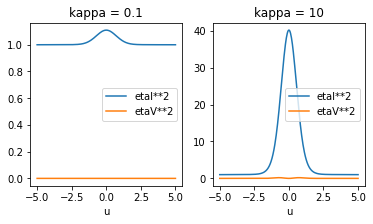

In [4]:
def fig_eta(ax, kappa, geff, uB): # u phi and dphi are defined in cell above. 
    etaI = 1+kappa*phi
    etaV = kappa * geff * uB * dphi
    ax.plot(u, etaI**2, label='etaI**2')
    ax.plot(u, etaV**2, label='etaV**2')
    ax.set_xlabel('u')
    ax.set_title('kappa = {}'.format(kappa))
    ax.legend(loc=0)
    return()

fig, ax = plt.subplots(1,2, figsize=(6,3))
fig_eta(ax[0], 0.1, 1.0, 0.1)
fig_eta(ax[1], 10, 1.0, 0.1)

So we can use this approximation to simplify as such: 

$$V(0)=-\mu S_1~\frac{\eta_V}{(\eta_I^2-\eta_V^2)} \simeq -\mu S_1~\frac{\eta_V}{\eta_I^2} $$

The figure below checks that this is a fine approximation under the approximations above. 

()

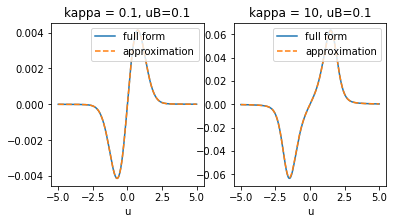

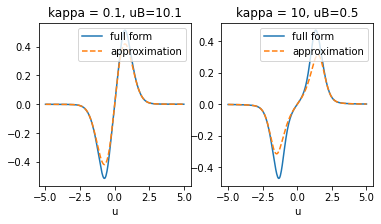

In [5]:
def fig_V(ax, kappa, geff, uB, muS1): # u phi and dphi are defined in cell above. 
    etaI = 1+kappa*phi
    etaV = kappa * geff * uB * dphi
    ax.plot(u, -muS1 * etaV / (etaI**2-etaV**2), label='full form')
    ax.plot(u, -muS1 * etaV / (etaI**2), label='approximation', ls='--')
    ax.set_xlabel('u')
    ax.set_title('kappa = {}, uB={}'.format(kappa, uB))
    ax.legend(loc=0)
    return()

fig, ax = plt.subplots(1,2, figsize=(6,3))
fig_V(ax[0], 0.1, 1.0, 0.1, 1.0)
fig_V(ax[1], 10, 1.0, 0.1, 1.0)
fig, ax = plt.subplots(1,2, figsize=(6,3))
fig_V(ax[0], 0.1, 1.0, 10.1, 1.0)
fig_V(ax[1], 10, 1.0, 0.5, 1.0)

To be more explicit, as long as $u_B$ is small, it is OK no matter what $\kappa$ is.

But if $u_B$ is not so small, you can get away with more as far as the specific approximation above is concerned. The bottom row shows that at large kappa, you are still constrained to have a $u_B$ small enough because $\eta_I$ will be of the order of $\kappa$. But for a small $\kappa$, $\eta_I$ is of the order of 1, and $\eta_V$ is of the order of $u_B \kappa$. So is $\kappa$ is small, you can get away with a larger $u_B$ and the approximation above is still valid.
> However, such a large $u_B$ would NOT satisfy our previous approximation that the $\sigma_{rb}$ are only shifted a tiny bit with respect to the width of the profile. 

We can now get an expression as a function of $\phi$ by replacing the metric elements, which yields

$$V(0) = -\mu S_1 \frac{\kappa g_\mathrm{eff}u_B\frac{d\phi(u)}{du}}{(1 + \kappa \phi)^2} = g_\mathrm{eff}u_B \left[ \frac{- \mu S_1\kappa\frac{d\phi(u)}{du}}{(1 + \kappa \phi)^2} \right] $$

The second equality is just a re-arrangement of terms, because the term in bracket is equivalent to
$\frac{d}{du}\left[ 1 + \frac{\mu S_1}{(1+\kappa\phi)} \right]=\frac{dI(0)}{du}$. So that we can also write instead:

$$V(0) = g_\mathrm{eff}u_B \frac{dI(0)}{du}$$

If ones expand $u_B$, and backtracks from $u$ to wavelength, nothing that at the start of this discussion we assumed a purely longitudinal field, which can be seen as "what is the contribution to Stokes V of the longitudinal component of a given field", when if one replaces $B$ in the $u_B$ expression with $B\cos\theta$, we recover the weak field expression that was originally given in the section about the hardcoded units (section 1). 

$$V(0) =  \left[1.399624\times10^{-7}\frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]}\right] ~~  B_z[\mathrm{G}] ~g_\mathrm{eff}~ \frac{dI(0)}{du}, $$

where the constant is `constLorentz` and the term in parenthesis is calculated early on as `perGaussLorentz`.


Finally, this means that computationally we can take the derivative (e.g. numerically) of the local intensity profile at every grid point (because the local profile will change because $\mu$ changes). Alternatively, we can compute the derivative of $\phi$, which does not change, then use the first expression. 

The figure below shows that both expressions are identical indeed. 

()

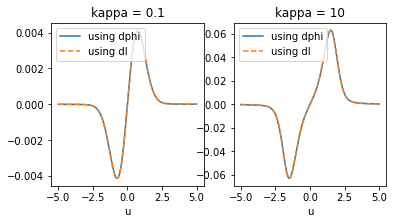

In [6]:
def fig_Vout(ax, kappa, geff, uB, muS1): # u phi and dphi are defined in cell above. 
    I = 1 + muS1/(1+kappa*phi)
    dI = np.gradient(I, u)
    V1 = -muS1 * kappa * geff * uB * dphi / (1 + kappa*phi)**2
    V2 = geff * uB * dI
    ax.plot(u, V1, label='using dphi')
    ax.plot(u, V2, label='using dI', ls='--')
    ax.set_xlabel('u')
    ax.set_title('kappa = {}'.format(kappa))
    ax.legend(loc=0)
    return()

fig, ax = plt.subplots(1,2, figsize=(6,3))
fig_Vout(ax[0], 0.1, 1.0, 0.1, 1.0)
fig_Vout(ax[1], 10, 1.0, 0.1, 1.0)

Finally to conclude this section, we can make a comparison with the local profile from the full unno solution for the local profiles (in the `profileV` module).

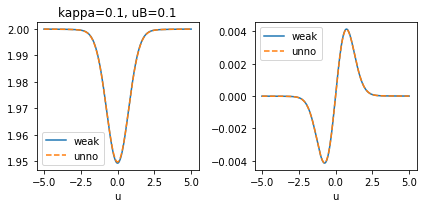

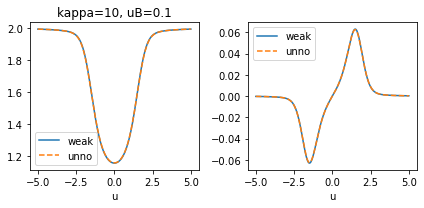

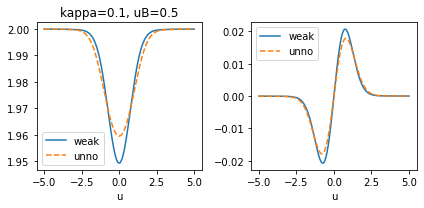

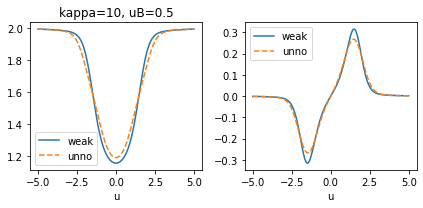

In [7]:
def comp_unno(kappa, uB):
    u = np.linspace(-5,5,300)
    phi = rav.profileI.voigt_fara(u, 0.05).real/np.sqrt(np.pi)
    w = rav.profileI.voigt_fara(u, 0.05)
    # the np.sqrt(np.pi) is taken into account inside the local_out function
    dphi = np.gradient(phi, u)


    geff=1.0
    muS1 = 1.0


    I = 1 + muS1/(1+kappa*phi)
    V = -muS1 * kappa * geff * uB * dphi / (1 + kappa*phi)**2 # Using the dphi expression.

    # Getting a triplet zeeman pattern with a geff=1
    pat = rav.pattern.zeeman_pattern([0,0,0], [0, 1, 1]) #zeeman pattern with geff=1
    # setting the ua=0, sintheta=0, costheta=1, and mu=1, S1(=bnu)=1
    unno = rav.localV.unno_local_out_IV(uB, 0, pat, u, w, u, 0, 1, 0, 0, kappa, 1, 1)

    fig, ax = plt.subplots(1,2,figsize=(6,3))
    ax[0].plot(u, I, label='weak')
    ax[0].plot(u, unno['I'], label='unno', ls='--')
    ax[0].set_title('kappa={}, uB={}'.format(kappa, uB))
    ax[1].plot(u,V, label='weak')
    ax[1].plot(u,-1*unno['V'], label='unno', ls='--') #-1* to follow Doanti's convention
    for item in ax:
        item.set_xlabel('u')
        item.legend(loc=0)
    plt.tight_layout()

comp_unno(0.1, 0.1)
comp_unno(10, 0.1)
comp_unno(0.1, 0.5)
comp_unno(10, 0.5)

The last two rows show what happens when the $u_B$ gets too large. 

## 3. The expressions for the angles used in the Unno solution

We obtained the B field vectors in LOS coordinates (B_LOS) with the rotation matrix. 

For the weak field, we only need the component of the field in the line of sign (the zLOS direction), so we only need the z component of B_LOS (`B_LOS[2,:]`).

For the Unno solution, we need two values: 
* $\cos(\theta)$ and $\sin(\theta)$, where $\theta$ is the angle between the B-field vector and the z axis and
* $\cos(2\phi)$ and $\sin(2\phi)$, where $\phi$ is the angle between the projection of the Bfield vector in the plane of the sky (xy) and the reference direction (here we'll use the x-axis)

If we use the unit vector in the direction of B, then $\cos(\theta)$ is straightfowardly the z component of B_LOS (`B_LOS[2,:]`). 

We can get $\sin(\theta) = \sqrt{1-\cos^2(\theta)}$. This is also the projection of the Bfield vector on the xy plane (i.e. $\sqrt{\hat{B}_x^2+\hat{B}_y^2}$).

Now, $\cos{\phi}$ is $\frac{\hat{B}_x}{\sin(\theta)}$ 

We can use trig identity to get the cos and sin of the double angles:
$$\cos(2\phi) = 2\cos^2\phi - 1 = 2 \frac{\hat{B}_x^2}{\sin^2(\theta)} - 1 $$


$$\sin(2\phi) = 2\sin\phi\cos\phi = 2 \frac{\hat{B}_x}{\sin(\theta)} \frac{\hat{B}_y}{\sin(\theta)} = 2 \frac{\hat{B}_x\hat{B}_y}{\sin^2(\theta)} $$




## 4. The correspondance between the slope of the source function and the $\epsilon$ limb-darkening parameter from Grey

For a semi-infinite flat atmosphere, the intensity along an outgoing ray is:

$$I(\tau_z,u>0) = \int_{\tau_z'=\tau_z}^{\tau_z'=\infty} S(\tau_z')~ \mathrm{e}^{\frac{\tau_z-\tau_z'}{u}} ~ \frac{d\tau_z}{u}$$

where $u$ is the cosine of the angle between the ray and the normal to the surface, $S$ is the source function, and $\tau_z$ is the vertical optical depth (with $\tau_z=0$ at the surface). 

If we assume that the source function is a linar function of the optical depth:
$$S(\tau_z) = S_{0} + S_{1} ~\tau_z$$

then the emergent intensity ($I(\tau_z=0$) becomes
$$I(\tau_z=0,~u>0) = S_{0} + S_{1} ~u$$

We can normalize the intensity by the intensity at the center of the stellar disk ($u=0):
$$\frac{I_\mathrm{obs}(u)}{I_\mathrm{obs}(u=1)} = \frac{S_{0} + S_{1} ~u}{S_{0} + S_{1}}$$

And we can also express this by parametrizing it with the slope/intercept, instead of having both be independent quantities:

$$\frac{I_\mathrm{obs}(u)}{I_\mathrm{obs}(u=1)} = \frac{1 + \frac{S_{1}}{S_0} ~u}{1 + \frac{S_{1}}{S_0}}$$

Finally, we can also quantify the limb-darkening by a value which represents the ratio of the limb intensity ($u=0$) and the center of the disk intensity ($u=1$):

$$\alpha = \frac{I_\mathrm{obs}(u=0)}{I_\mathrm{obs}(u=1)} = \frac{1 }{1 + \frac{S_{1}}{S_0}}$$

and its inverse:

$$ \frac{S_1}{S_0} = \frac{1}{\alpha} -1 = \frac{1-\alpha}{\alpha} $$

The graph below shows that for example, a slope parameter of unity yields a limb-darkening ratio of $\alpha=0.5$.

Text(0.5, 0, '$\\alpha=\\frac{I_\\mathrm{obs}(u=0)}{I_\\mathrm{obs}(u=1)}$')

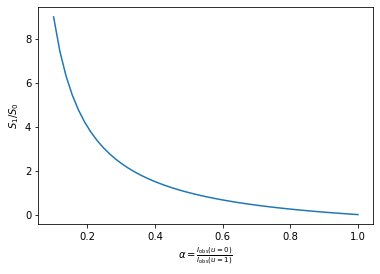

In [8]:
fig, ax = plt.subplots(1,1)

eps = np.linspace(0.1,1.0, 50)

S = 1/eps - 1

ax.plot(eps, S)

ax.set_ylabel('$S_1/S_0$')
ax.set_xlabel(r'$\alpha=\frac{I_\mathrm{obs}(u=0)}{I_\mathrm{obs}(u=1)}$')

We can also re-express our expression for $\frac{I_\mathrm{obs}(u)}{I_\mathrm{obs}(u=1)}$ in terms of this $\alpha$ ratio, instead of the source function slope parameter:

$$\frac{I_\mathrm{obs}(u)}{I_\mathrm{obs}(u=1)} = \frac{1+ \left[\frac{1}{\alpha}-1\right]u}{1+\left[\frac{1}{\alpha}-1\right]} $$

$$=\alpha + (1-\alpha)u.$$

But in the textbooks and papers, they instead use a quantity called the 'limb-darkening' coefficient, which is $\epsilon=1-\alpha$, and the equation above becomes

$$\frac{I_\mathrm{obs}(u)}{I_\mathrm{obs}(u=1)}  =(1-\epsilon) + \epsilon u. $$

So the bottom line is that if e.g. the limb-darkening ratio $\alpha$ is 0.4, then the limb-darkening coefficient $\epsilon$ is 0.6, and the source function slope parameter $S$ is 1.5.

## 5. The analytical rotation-broadened profiles

Let's start with an analytical expression for the non-rotating disk-integrated intensity line profile. 

From section XX, we know that the local intensity profiles are
$$I(\mu)=1+\frac{1}{1+\kappa\phi}S_1 \mu$$
and
$$I_c(\mu)=1+\mu S_1$$
A reminder that the wavelength dependence is inside of the $\phi$ profile function (which is the Voigt function divided by $\sqrt{\pi}$). 

The most straigthforward disk integration is to use the $\mu$ integral form (with azimuthal symmetry). 
$$F=2\pi\int_{\mu=o}^{+1} I(\mu)\mu d\mu$$
This leads to
$$F = \pi \left[1+\frac{2}{3} \frac{S_1}{1+\kappa\phi}\right]$$

We can also compute the continnum surface flux in the same way
$$F_\mathrm{surf}=2\pi\int_{\mu=o}^{+1} I_c(\mu)\mu d\mu$$
which yields
$$F_\mathrm{surf}=\pi \left[1+\frac{2}{3} S_1\right]$$

Thus we can expressed the line flux normalized to the continnum flux as
$$\frac{F}{F_c}=\frac{1+\frac{2}{3} \frac{S_1}{1+\kappa\phi}}{1+\frac{2}{3} S_1}$$

This is equivalent to the local itensity line profile normalized to the local continuum, aka
$$\frac{I(\mu)}{I_c(\mu)}=\frac{1+\mu \frac{S_1}{1+\kappa\phi}}{1+\mu S_1}$$
evaluated at $\mu=2/3$.


In the cell below, we show the agreement between the analytical solution and the numerical disk integration (under the weak field approximation). We also show the local intensity profile normalized to the local continuum at the center of the stellar disk for an array of $\mu$ values. 

Of course as shown above, the normalize flux corresponds to the local locally-normalized intensity at $\mu=2/3$. But I also want to emphasis here that the local profiles are not the same across the stellar disk.

No spectral resolution given, no PDF convolution performed
No macroturbulence velocity given, no convolution performed
Using 1000.0 grid point on the surface
Evaluating with weak approximation...


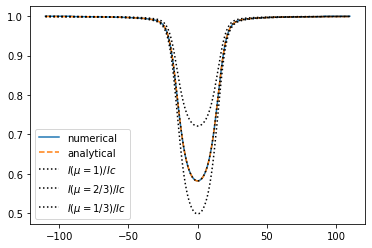

In [9]:
param = rav.params.get_def_param_weak()
param["general"]["vsini"]=0.0

model_num = rav.diskint2.numerical(param,unno=False)

phi = rav.profileI.voigt_fara(model_num["uo"], param["general"]["av"]).real/np.pi**0.5
S1 = param["general"]["bnu"]
kappa = 10**param["general"]["logkappa"]
model_ana = (1+2/3*S1/(1+kappa*phi)) / (1+2/3*S1)

def I_Ic(mu):
    return( (1+mu*S1/(1+kappa*phi)) / (1+mu*S1) )

fig, ax = plt.subplots(1,1)
ax.plot(model_num['vel'], model_num['flux'], label='numerical')
ax.plot(model_num['vel'], model_ana, ls='--', label='analytical')
ax.plot(model_num['vel'], I_Ic(1.0), ls='dotted', c='k', label=r'$I(\mu=1)/Ic$')
ax.plot(model_num['vel'], I_Ic(2/3), ls='dotted', c='k', label=r'$I(\mu=2/3)/Ic$')
ax.plot(model_num['vel'], I_Ic(1/3), ls='dotted', c='k', label=r'$I(\mu=1/3)/Ic$')


ax.legend(loc=0)

Now, let's make the star rotate. Following the Grey textbook, we define the direction that is perpendicular to the plane subtended by the LOS and the rotational axis as $\hat{x}$. 
ADD FIGURE
Therefore positions on the stellar disk with the same x-coordinate all have the same rotational projected velocity. The local profile at these location will be doppler shifted by $v_z=x~v\sin i$. 

From earlier, the line intensity normalized to the continnum flux is
$$\frac{I(\mu)}{I_c(\mu)}=\frac{1+\mu \frac{S_1}{1+\kappa\phi}}{1+\mu S_1}\equiv H(v,\mu)$$
and I will below refer to it as $H(v,\mu)$.

This means that I can flip this around and express the line intensity (not normalized) as
$$I(v,\mu) = H(v-v_z(\mu), \mu)~I_c(\mu)$$
where the $-v_z$ term takes care of the Doppler shift. 

Ok, so here's the thing -- this is not a great expression, as there are two $\mu$ dependencies in the $H$ term, one intrinsic the the $I$ function and the other from the Doppler shift. So the idea here will be to ignore the intrinsic dependency on $\mu$ and say that the shape of the intensity line profile (normalized to the local continuum) is constant across the stellar disk (I know, in the previous cell I have just shown how this is not the case, but bear with me). 

So,
$$I(v,\mu) \approx H(v-v_z(\mu))~I_c(\mu)$$
and we can write the normalized flux as:
$$\frac{F(v)}{F_c}=\frac{\int_\mathrm{surf} H(v-v_z(\mu))~I_c(\mu)}{\int_\mathrm{surf}I_c(\mu)}$$

We have already dealt with the denominator of this equation above, so I will just refer to it as $F_c$ for now. 

Here, we will do the disk integration in the numerator in cartesian, to use the fact that all the locations with the same $x$ value have the same $v_z$. To integrate a circle in cartesian, we will go from $-1$ to $+1$ in $x$, and for each $x$ value, the $y$ integral will be bounded by $y(x)=\pm (1-x^2)^{1/2}$. Thus:
$$\frac{F(v)}{F_c}=\frac{1}{F_c} \int_{x=-1}^{+1}\int_{-y(x)}^{+y(x)} H(v-v_z(x))~I_c(x,y)dydx$$

Also, we can make a change of variable to use $v_z$ intead of $x$. As $v_z=x~v\sin i$, then $dv_z=dx~v\sin i$, and when $x=\pm1$, then $v_z=\pm v\sin i$. 
$$\frac{F(v)}{F_c}=\frac{1}{F_c} \int_{v_z=-v\sin i}^{+v\sin i}\int_{-y(v_z)}^{+y(v_z)} H(v-v_z)~I_c(v_z,y)dy\frac{dv_z}{v\sin i}$$

Note that as $F_c$ is a constant, I can pull it back into the integral. Finally, because $H$ is only a function of $x$ ($v_z$ now), I can pull that term out of the $y$ integral. Thus:

$$\frac{F(v)}{F_c}= \int_{v_z=-v\sin i}^{+v\sin i} H(v-v_z) \left[ \frac{\int_{-y(x)}^{+y(x)} ~I_c(v_z,y)dy}{v\sin i~ F_c}\right]dv_z$$

All right, now let's call the piece in [] in the previous expression $G(v_z)$. As $y$ will have been integrated out, the result it will not be a function of $y$. Additionally, this is not a function of $v$, just $v_z$ as an encoded of location on the stellar disk. We are left with:
$$\frac{F(v)}{F_c}= \int_{v_z=-v\sin i}^{+v\sin i} H(v-v_z) G(v_z)dv_z$$
We can also note that $G(Vz)$ will be zero when $v_z>v\sin i$ -- remember, we are using $v_z$ as a proxy for $x$, and inside the $y$ integral above, $I(\mu)=0$ outside of the stellar disk. This means that mathematically, we can change the bounds of the $v_z$ integral to go to infinity without changing the physics. 

$$\frac{F(v)}{F_c}= \int_{v_z=-\infty}^{+\infty} H(v-v_z) G(v_z)dv_z$$

Why, you might ask? Well, because the equation in this form is the basic equation for a convolution:
$$(h*g)(v)=\int_{-\infty}^{+\infty}h(v-v_z)g(v_z)dv_z$$

This means that if I have my line profile function $H$, and the $G(v_z)$ function, I can simply take the (numerical) convolution of them. 

So now two questions remains:
1. What is $G(v_z)$
2. What do I use for $H(v)$, if I made the approximation that the intensity profile is constant across the stellar disk (which it is not).

Let's start with $G(v_z)$ by returning to the expression in [] from a bit above:
$$G(v_z)=\left[ \frac{\int_{-y(v_z)}^{+y(v_z)} ~I_c(v_z,y)dy}{v\sin i~ F_c}\right]$$

We will first note that this integral should be symmetric above and below $y=0$, so I can write is as

$$G(v_z)= \frac{2}{v\sin i~ F_c} \int_0^{+y(v_z)} ~(1+\mu S_1)dy$$

The bound of the integral depends on the value of $v_z$, as already explained in the cartesian integral setup in the previous cell:
$$y(v_z)=(1-x^2)^{1/2}=\left[1-\left(\frac{v_z}{v\sin i}\right)^2\right]^{1/2} \equiv y_o$$
For clarity below, I will shorten the $y(v_z)$ expression for $y_o$. 

So now we need to express $\mu$ in terms of cartesian coordinates. The radial coordinate of the stellar disk (usually refered to as $p$) is related to the $\theta$ angle (the angle between the LOS and the normal to the surface) by $p=\sin\theta$ (using the radius in $R_\star$ units), thus $p^2=1-\mu^2$. Furthermore using the cartesian coordinates $p^2=x^2+y^2$, so $\mu^2=1-x^2-y^2$. We can substitute $x$ in favor of $v_z$ such that
$\mu^2 = 1-\left(\frac{v_z}{v\sin i}\right)^2-y^2$, or using the $y_o$ I introduced earlier $\mu^2=y_o^2-y^2$. 

The flux expression becomes:

$$G(v_z)= \frac{2}{v\sin i~ F_c} \int_0^{+y_o} ~(1+ S_1(y_o^2-y^2)^{1/2})dy$$

Evaluating the integral yields:

$$G(v_z)= \frac{2}{v\sin i~ F_c} y_o + S_1 \frac{\pi}{4} y_o^2$$

We can now use the expression for $F_c=\pi\left(1+\frac{2}{3}S_1\right)$ from earlier and expand $y_o$ such that:

$$G(v_z)= \frac{2\left(1-\left[\frac{v_z}{v\sin i}\right]^2\right)^{1/2} + \frac{\pi}{2}S_1 \left(1-\left[\frac{v_z}{v\sin i}\right]^2\right)}{\pi v\sin i \left(1+\frac{2}{3}S_1\right)}$$

NOTE: by using the equvalence between $S_1$ and the $\epsilon$ parameter from the Grey textbook, explained in Section XX, we can recover the expression for the rotation kernel from Grey (the velocity expresison is given in the 2nd edition -- the first edition only has the wavelength form)

$$G(v_z)= \frac{2(1-\epsilon)\left(1-\left[\frac{v_z}{v\sin i}\right]^2\right)^{1/2} + \frac{\pi}{2}\epsilon \left(1-\left[\frac{v_z}{v\sin i}\right]^2\right)}{\pi v\sin i \left(1-\frac{1}{3}\epsilon\right)}$$

In the cell below, we show the rotation convolution kernel from the expression in terms of $S_1$ (which imo is simpler) and with the expression from Grey. A reminder that $S_1=1.5$ corresponds to $\epsilon=0.6$. 

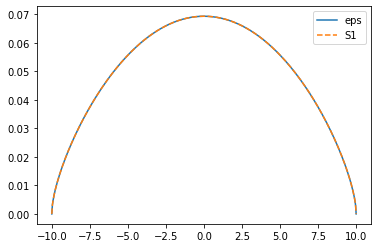

In [10]:
S1 = 1.5
eps = 0.6

vz = np.linspace(-10,10,501)
vsini = 10.0

yo = 1-(vz/vsini)**2

G_eps = (2*(1-eps)*yo**0.5+0.5*np.pi*eps*yo) / (np.pi*vsini*(1-eps/3))

G_s1 = (2*yo**0.5 + 0.5*S1*np.pi*yo) / (np.pi*vsini*(1+2/3*S1))

fig, ax = plt.subplots(1,1)

ax.plot(vz, G_eps, label='eps')
ax.plot(vz, G_s1, ls='--', label='S1')

ax.legend(loc=0)

Now that we have an expression for the rotational kernel, we can use it to convolve it with the $H(\nu)$ function. It is not apriori clear which function to use for it, as the derivation above assumend that the local line profile normalized by the local continnum is function across the stellar disk (which isn't). 

It would make sense to want to recover the expression for the non-rotating disk-integrated profile in the limiting case where $v\sin i$ is zero. So we will use $H(\nu)$ as being the analytical expression for the flux in the non-rotating case above (including the line limb-darkening), which also, as we mentioned above, is the local intensity normalized to the local continuum when $\mu=2/3$). 

The `rav.diskint2.analytical(param)` function accepts a parameter dictionary. The necessary keywords are:
* INSERT LIST HERE

In the cell below, we show the comparison between the full numerical disk integration and the convolution calculation. 

ADD SOME ILLUSTRATIONS OF THE VALIDITY OF THE APPROXIMATION MADE FOR VARIOUS VSINI AND LIMB-DARKENING. 

No spectral resolution given, no PDF convolution performed
No macroturbulence velocity given, no convolution performed
Using 1000.0 grid point on the surface
Evaluating with weak approximation...
No spectral resolution given, no PDF convolution performed
No macroturbulence velocity given, no convolution performed
Using 1000 grid point on the surface
Evaluating with weak approximation...


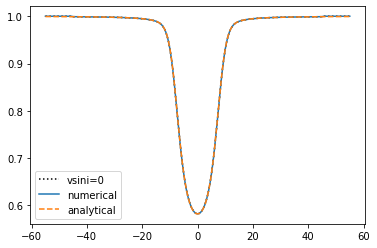

In [11]:
fig, ax = plt.subplots(1,1)

param = rav.params.get_def_param_weak()
param["general"]["vdop"]=5.0
param["general"]["bnu"]=1.5
#param.pprint()

param["general"]["vsini"]=0.0
numerical = rav.diskint2.numerical(param, unno=False)
ax.plot(numerical["vel"], numerical["flux"], c='k', ls='dotted', label='vsini=0')


param["general"]["vsini"]=0
numerical = rav.diskint2.numerical(param, unno=False)
ax.plot(numerical["vel"], numerical["flux"], label='numerical')

model = rav.diskint2.analytical(param)
ax.plot(model["vel"], model["flux"], label='analytical', ls='--')

ax.legend(loc=0)


In [12]:
#How quick is that code?
import time

param = rav.params.get_def_param_weak()
param["general"]["vdop"]=5.0
param["general"]["bnu"]=1.5
#param.pprint()

param["general"]["vsini"]=350.0

tic = time.time()
numerical = rav.diskint2.numerical(param, unno=False)
toc = time.time()
print(toc - tic)

tic = time.time()
for i in range(0,300):
    model = rav.diskint2.analytical(param)
toc = time.time()
print(toc - tic)

No spectral resolution given, no PDF convolution performed
No macroturbulence velocity given, no convolution performed
Using 15000.0 grid point on the surface
Evaluating with weak approximation...
2.253340482711792
1.9116525650024414


## 6. Convolution with macroturbulence and instrument resolution

For simplicity, we will assume that both the macroturbulent broadening and the spectral PSF have gaussian shapes. 

Because the convolution of two gaussian is itself a gaussian, we only need to calculate one combined kernel for the macroturbulent and instrument broadening. 

A function $f(t)$ is a Gaussian such that
$$f(t)=\frac{1}{\sqrt{\pi}\sigma_f}\mathrm{e}^{-\frac{t^2}{2\sigma_t^2}}$$

The Fourrier transform is:
$$FT(f(t))(\nu) = \int_{-\infty}^{\infty}f(t)\mathrm{e}^{-2\pi i\nu t}dt$$
Replacing $f(t)$ yields:
$$FT(f(t))(\nu) = \int_{-\infty}^{\infty}\frac{1}{\sqrt{\pi}\sigma_f}\mathrm{e}^{-\frac{t^2}{2\sigma_t^2}}\mathrm{e}^{-2\pi i\nu t}dt$$

Expanding the second exponentinal using euler's formula gives:
$$FT(f(t))(\nu) = \frac{1}{\sqrt{\pi}\sigma_f} \int_{-\infty}^{\infty}\mathrm{e}^{-\frac{t^2}{2\sigma_t^2}} \left[\cos(2\pi \nu t)+i\sin(2\pi \nu t) \right]dt$$

We can split the integral in two:
$$FT(f(t))(\nu) = \frac{1}{\sqrt{\pi}\sigma_f} \left[ \int_{-\infty}^{\infty}\mathrm{e}^{-\frac{t^2}{2\sigma_t^2}} \cos(2\pi \nu t)dt+ \int_{-\infty}^{\infty}\mathrm{e}^{-\frac{t^2}{2\sigma_t^2}}i\sin(2\pi \nu t)dt \right]$$

The second integral is the area under the multiplication of an even function and a odd function, meaning that the integral will be zero. 

For the first integral, we make the change of variable $x=\pi t$, and we set $a=1/(2\pi^2\sigma_f^2)$ so that:
$$FT(f(t))(\nu) = \frac{1}{\pi\sqrt{\pi}\sigma_f}  \int_{-\infty}^{\infty}\mathrm{e}^{-ax^2} \cos(2x \nu )dx$$
We also note that the integrand is a symmetric function about zero, so that the total integral will be twice the integral in the positive $x$ domain. 
$$FT(f(t))(\nu) = \frac{2}{\pi\sqrt{\pi}\sigma_f}  \int_{0}^{\infty}\mathrm{e}^{-ax^2} \cos(2x \nu )dx$$
The definite integral is known:
$$FT(f(t))(\nu) = \frac{2}{\pi\sqrt{\pi}\sigma_f}  \frac{1}{2}\sqrt{\frac{\pi}{a}}\mathrm{e}^{-\frac{\nu^2}{a}}$$
Replacing $a$ and cancelling terms yields:
$$FT(f(t))(\nu) = \mathrm{e}^{-a\pi^2\sigma_f^2 \nu^2}$$

If we have a function $g(t)$ which is also a Gaussian with $\sigma_g$, then its transform will similarly be
$$FT(g(t))(\nu) = \mathrm{e}^{-a\pi^2\sigma_g^2 \nu^2}$$

From the convolution theorem, we know that $FT(f*g) = FT(f)\cdot FT(g)$. 
Thus
$$FT(t*g)=\mathrm{e}^{-a\pi^2\sigma_f^2 \nu^2}\mathrm{e}^{-a\pi^2\sigma_g^2 \nu^2}$$
which reduces to
$$FT(t*g)=\mathrm{e}^{-a\pi^2 (\sigma_f^2+\sigma_g^2) \nu^2}$$

We can see that this corresponds to the FT of a Gaussian function that would have a $\sigma$ equal to $\sqrt{\sigma_f^2+\sigma_g^2}$. 
From this we conclude that:

$$g*t = \frac{1}{\sqrt{\pi(\sigma_f^2+\sigma_g^2)}} \mathrm{e}^{-\frac{t^2}{2(\sigma_t^2+\sigma_g^2)}}$$




We consider that the macroturbulence velocity corresponds to the sigma of the gaussian. 

The spectral resolution is defined in the code with $R$ such that
$$ R=\frac{\lambda}{\Delta\lambda}=\frac{c}{\Delta v}$$
Thus the spectral resolution element ($\Delta \lambda$ or $\Delta v$) is usually taken to be the FWHM of the PSF. Therefore the $\sigma$ in km/s of the gaussian PDF is
$$\sigma=\frac{1}{\sqrt{8\ln 2}}\frac{c}{R}$$ 
where $c$ is in km/s. 

We therefore defined the total $\sigma$ in $u_o$ units to be

$$u_\mathrm{conv} = \frac{\sqrt{\sigma_\mathrm{res}^2+\sigma_\mathrm{macro}^2}}{v_\mathrm{therm}}$$

During the disk integration part of the code, the dispersion array (in $u_o$) unit has a size of $u_\mathrm{rot}+10$, where the latter means that the Voigt profile is calculated out to 10 sigma (remember that in $u_o$ units, the 'width' of the Voigt profile, akin to its $\sigma$, is 1.)

To accomodate the convolution with the resolution and macroturbulence, we have to extend the dispersion array (and pad line profile array accordingly) by $10\times u_\mathrm{conv}$ (we are calculating the gaussian convolution profile up to 10 sigma). 

In the cell below, we test the convolution capabilities

No spectral resolution given, no PDF convolution performed
No macroturbulence velocity given, no convolution performed
Using 1400 grid point on the surface
Evaluating with weak approximation...
1.958617462625618
Using 1400 grid point on the surface
Evaluating with weak approximation...


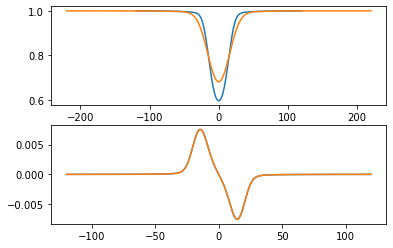

In [29]:
param = rav.params.get_def_param_weak()
#param.pprint()
param['general']['vsini']=10

model = rav.diskint2.numerical(param,False)

fig, ax = plt.subplots(2,1)
ax[0].plot(model['vel'], model['flux'])
ax[1].plot(model['vel'], model['V'])

import copy
param2 = copy.deepcopy(param)
param2['general'].update({'res': 65000.})
param2['general'].update({'vmac': 10.})
model2 = rav.diskint2.numerical(param2,False)

ax[0].plot(model2['vel'], model2['flux'])
ax[1].plot(model['vel'], model['V'])


No spectral resolution given, no PDF convolution performed
No macroturbulence velocity given, no convolution performed
Using 1400 grid point on the surface
Evaluating with unno method...
Max shift due to field: 0.0349906123404163 vdop
Max shift due to vsini: 1.0 vdop
1.958617462625618
Using 1400 grid point on the surface
Evaluating with unno method...
Max shift due to field: 0.0349906123404163 vdop
Max shift due to vsini: 1.0 vdop


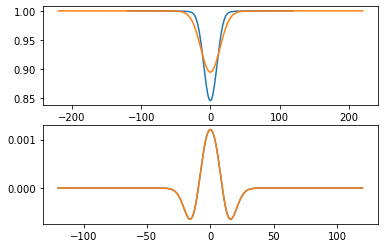

In [30]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':30.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':0.0,          # the line strength parameter
    'ndop':int(10),       # the number of sample point per doppler width for the wavelength array
    'Bpole':500,
    'incl':90, #not necessary for loop
    'beta':90, #not necessary for loop
    'phase':90 #not necessary for loop
  }

unnoparam = {
    'down':[0, 0, 0],   # the s, j, l of the lower level
    'up':[0, 1, 1],    # the s, j, l of the upper level
    }

weakparam = {
        'geff':1.0
    }
    
param={'general' : genparam,
       'weak' : weakparam,
       'unno': unnoparam # no necessary for loop
       }


param['general']['vsini']=10

model = rav.diskint2.numerical(param,True)

fig, ax = plt.subplots(2,1)
ax[0].plot(model['vel'], model['flux'])
ax[1].plot(model['vel'], model['V'])

import copy
param2 = copy.deepcopy(param)
param2['general'].update({'res': 65000.})
param2['general'].update({'vmac': 10.})
model2 = rav.diskint2.numerical(param2,True)

ax[0].plot(model2['vel'], model2['flux'])
ax[1].plot(model['vel'], model['V'])

## Testing the code

In the cell below, I prepared a model that can be passed to diskint. 

The pattern for Unno is a triplet with a geff of 1.0. 

In addition to returning the final result itself, I added a line in the disk integration look that returns one of the local profile (e.g. the fifth one in the loop), which was useful for debugging. 

NOTE that once everything is debug, this will be commented out in diskint, so the graph cells below will not work anymore. 

In [14]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':30.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':0.0,          # the line strength parameter
    'ndop':int(10),       # the number of sample point per doppler width for the wavelength array
    'Bpole':500,
    'incl':90, #not necessary for loop
    'beta':90, #not necessary for loop
    'phase':90 #not necessary for loop
  }

unnoparam = {
    'down':[0, 0, 0],   # the s, j, l of the lower level
    'up':[0, 1, 1],    # the s, j, l of the upper level
    }

weakparam = {
        'geff':1.0
    }
    
param={'general' : genparam,
       'weak' : weakparam,
       'unno': unnoparam # no necessary for loop
       }

pat = rav.pattern.zeeman_pattern(unnoparam['down'], unnoparam['up'])
#rav.pattern.plot_zeeman_pattern(pat)

In [15]:
import time

tic = time.time()
#model_unno, testI_unno, testV_unno = rav.diskint2.numerical(param, unno=True)
model_unno = rav.diskint2.numerical(param, unno=True)
toc = time.time()
print(toc - tic)

tic = time.time()
#model_weak, testI_weak, testV_weak = rav.diskint2.numerical(param, unno=False)
model_weak = rav.diskint2.numerical(param, unno=False)
toc = time.time()
print(toc - tic)

No spectral resolution given, no PDF convolution performed
No macroturbulence velocity given, no convolution performed
Using 2200.0 grid point on the surface
Evaluating with unno method...
Max shift due to field: 0.0349906123404163 vdop
Max shift due to vsini: 3.0 vdop


0.6647441387176514
No spectral resolution given, no PDF convolution performed
No macroturbulence velocity given, no convolution performed
Using 2200.0 grid point on the surface
Evaluating with weak approximation...
0.14200234413146973


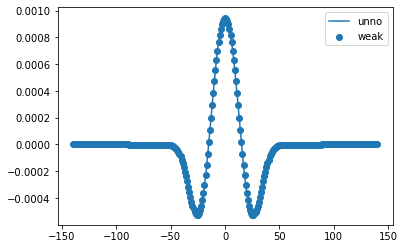

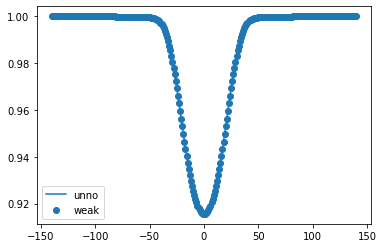

In [16]:
#fig, ax = plt.subplots(1,1)

#ax.plot(model_unno['uo'], testV_unno, label='unno')
#ax.scatter(model_weak['uo'], testV_weak, label='weak')
#ax.legend(loc=0)

#fig, ax = plt.subplots(1,1)

#ax.plot(model_unno['uo'], testI_unno, label='unno')
#ax.scatter(model_weak['uo'], testI_weak, label='weak')
#ax.legend(loc=0)

fig, ax = plt.subplots(1,1)

ax.plot(model_unno['vel'], model_unno['V'], label='unno')
ax.scatter(model_weak['vel'], model_weak['V'], label='weak')

ax.legend(loc=0)

fig, ax = plt.subplots(1,1)

ax.plot(model_unno['vel'], model_unno['flux'], label='unno')
ax.scatter(model_weak['vel'], model_weak['flux'], label='weak')

ax.legend(loc=0)

## Is it quick to interpolate or to recalculate w?

In [17]:
import time

#for vsini = 250, -32 to 32, with 6600 points

all_u = np.linspace(-32,32,6600)
small_u = np.linspace(-7,7, 10*2*7)

tic = time.time()
for i in range(0,1000):
    w = rav.profileI.voigt_fara(all_u, 0.05)
toc = time.time()
print(toc - tic)


w = rav.profileI.voigt_fara(small_u, 0.05).real

tic = time.time()
for i in range(0,1000):
    toto = rav.localV.interpol_lin(w,  small_u, all_u)
toc = time.time()
print(toc - tic)


20.34989094734192
0.18098068237304688
